In [1]:
import os
import pandas as pd
from PIL import Image
from PIL import ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import json

In [18]:
path2zettel: str = "Z:/MLW/zettel/"
path2datajson: str = "Z:/MLW/data.json"
path2output: str = "../../data/raw/output_v2"

In [31]:
def load_output(path: str) -> pd.DataFrame:
    """Load and Process Output File.

    Loads and processes output file labeled by the previous visual grounding
    model. Besides coordinates of BBs, length and height are also added to
    the DataFrame. All BBs, that start at 0.0, 0.0 are dropped and considered
    a failure.

    :param path: Path to output file.
    :return: DataFrame of imported output file.
    """
    output: any = open(str(path),"r")
    output = output.read()
    output = output.split("/n")
    del output[6000]
    output = [json.loads(d) for d in output]

    id = [d["file"].split(".")[0] for d in output]
    x1 = [d["result"][0]["box"][0] for d in output]
    y1 = [d["result"][0]["box"][1] for d in output]
    x2 = [d["result"][0]["box"][2] for d in output]
    y2 = [d["result"][0]["box"][3] for d in output]

    outputs_bb = pd.DataFrame(np.array([id,x1,y1,x2,y2]).T, columns=["id","x1","y1","x2","y2"])

    outputs_bb['id'] = outputs_bb['id'].astype("int64")
    outputs_bb['x1'] = round(outputs_bb['x1'].astype("float"))
    outputs_bb['y1'] = round(outputs_bb['y1'].astype("float"))
    outputs_bb['x2'] = round(outputs_bb['x2'].astype("float"))
    outputs_bb['y2'] = round(outputs_bb['y2'].astype("float"))

    # Getting the length and height of the Bounding Boxes
    outputs_bb["length"] = outputs_bb["x2"] - outputs_bb["x1"]
    outputs_bb["height"] = outputs_bb["y2"] - outputs_bb["y1"]

    # Removing all BBs with a length larger than 1600
    outputs_bb_df = outputs_bb[(outputs_bb["length"]<1600)& (outputs_bb["height"]<1000)].copy()
    return outputs_bb_df

In [20]:
def load_data_json(path: str) -> pd.DataFrame:
    """ Load data.json.

    Load `data.json` file from main data ('MLW') directory.

    :param path: Path to data.json in the  '<drive>/MLW' directory.
    :return: DataFrame of imported data.
    """
    f = open(path)
    data = json.load(f)
    data = pd.DataFrame(data)
    data["length_lemma"] = [len(i) for i in data["lemma"]]
    return data

In [21]:
def create_dataset(path2datajson: str, path2output: str) -> pd.DataFrame:
    """Create Dataset to Label.

    Function to merge output and data.json datasets. Both datasets are
    first loaded and subsequently merged.

    :param path2datajson: Path to `data.json` file.
    :param path2output: Path to `output` file.
    :return: Merged Dataset.
    """
    datajson: pd.DataFrame = load_data_json(path2datajson)
    dataoutput: pd.DataFrame = load_output(path2output)
    data: pd.DataFrame = datajson.merge(dataoutput, on="id")
    return data

In [32]:
data: pd.DataFrame = create_dataset(path2datajson, path2output)

# Scatterplots

### LemmaLen x Length

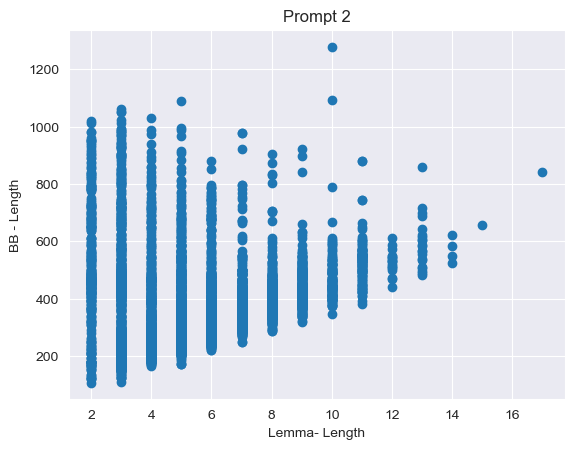

In [35]:
plt.scatter(data['length_lemma'], data['length'])
plt.title("Prompt 2")
plt.xlabel("Lemma- Length")
plt.ylabel("BB - Length")
plt.savefig("../../../graphics/2_BBs-OFA/LLength-Length_v2.jpg")

### LemmaLen x Height

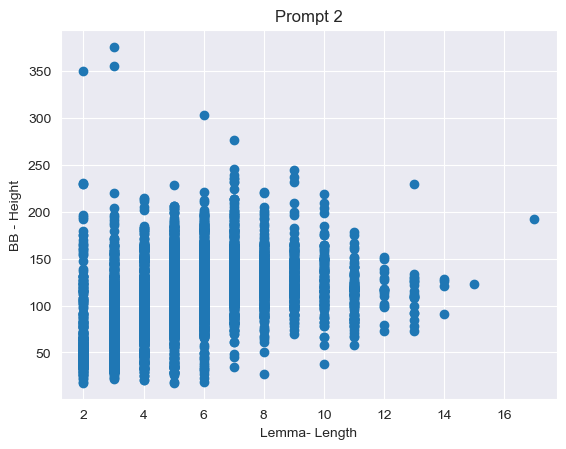

In [36]:
plt.scatter(data['length_lemma'], data['height'])
plt.title("Prompt 2")
plt.xlabel("Lemma- Length")
plt.ylabel("BB - Height")
plt.savefig("../../../graphics/2_BBs-OFA/LLength-Height_v2.jpg")

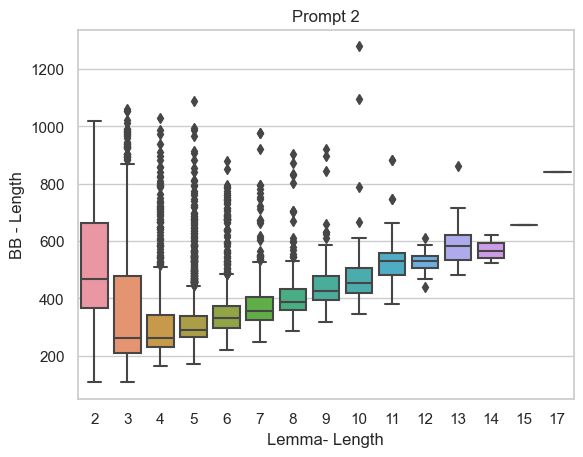

In [44]:
sns.set(style='whitegrid')
data_v = data.copy()
data_v["length_lemma"] = data_v["length_lemma"].astype("str")
length_lemma = list(map(str,data.groupby(["length_lemma"])["length"].mean().index.to_list()))
sns.boxplot(data = data_v, x = "length_lemma", y = "length", order=length_lemma).set_title("Prompt 2")
plt.xlabel("Lemma- Length")
plt.ylabel("BB - Length")
plt.savefig('../../../graphics/2_BBs-OFA/BP-Length_v2.png')

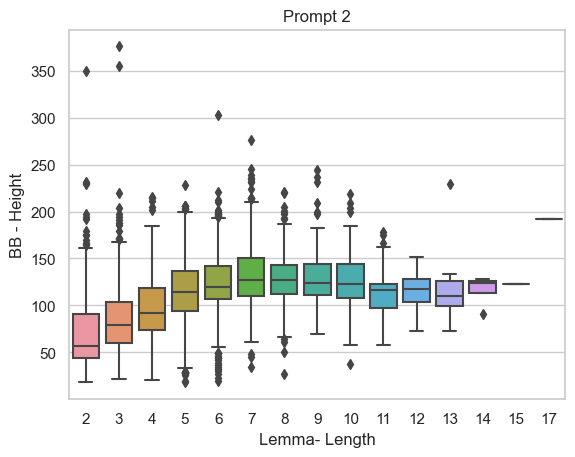

In [46]:
sns.set(style='whitegrid')
length_lemma = list(map(str,data.groupby(["length_lemma"])["length"].mean().index.to_list()))
sns.boxplot(data=data_v, x="length_lemma", y="height", order=length_lemma).set_title("Prompt 2")
plt.xlabel("Lemma- Length")
plt.ylabel("BB - Height")
plt.savefig('../../../graphics/2_BBs-OFA/BP-Height_v2.png')

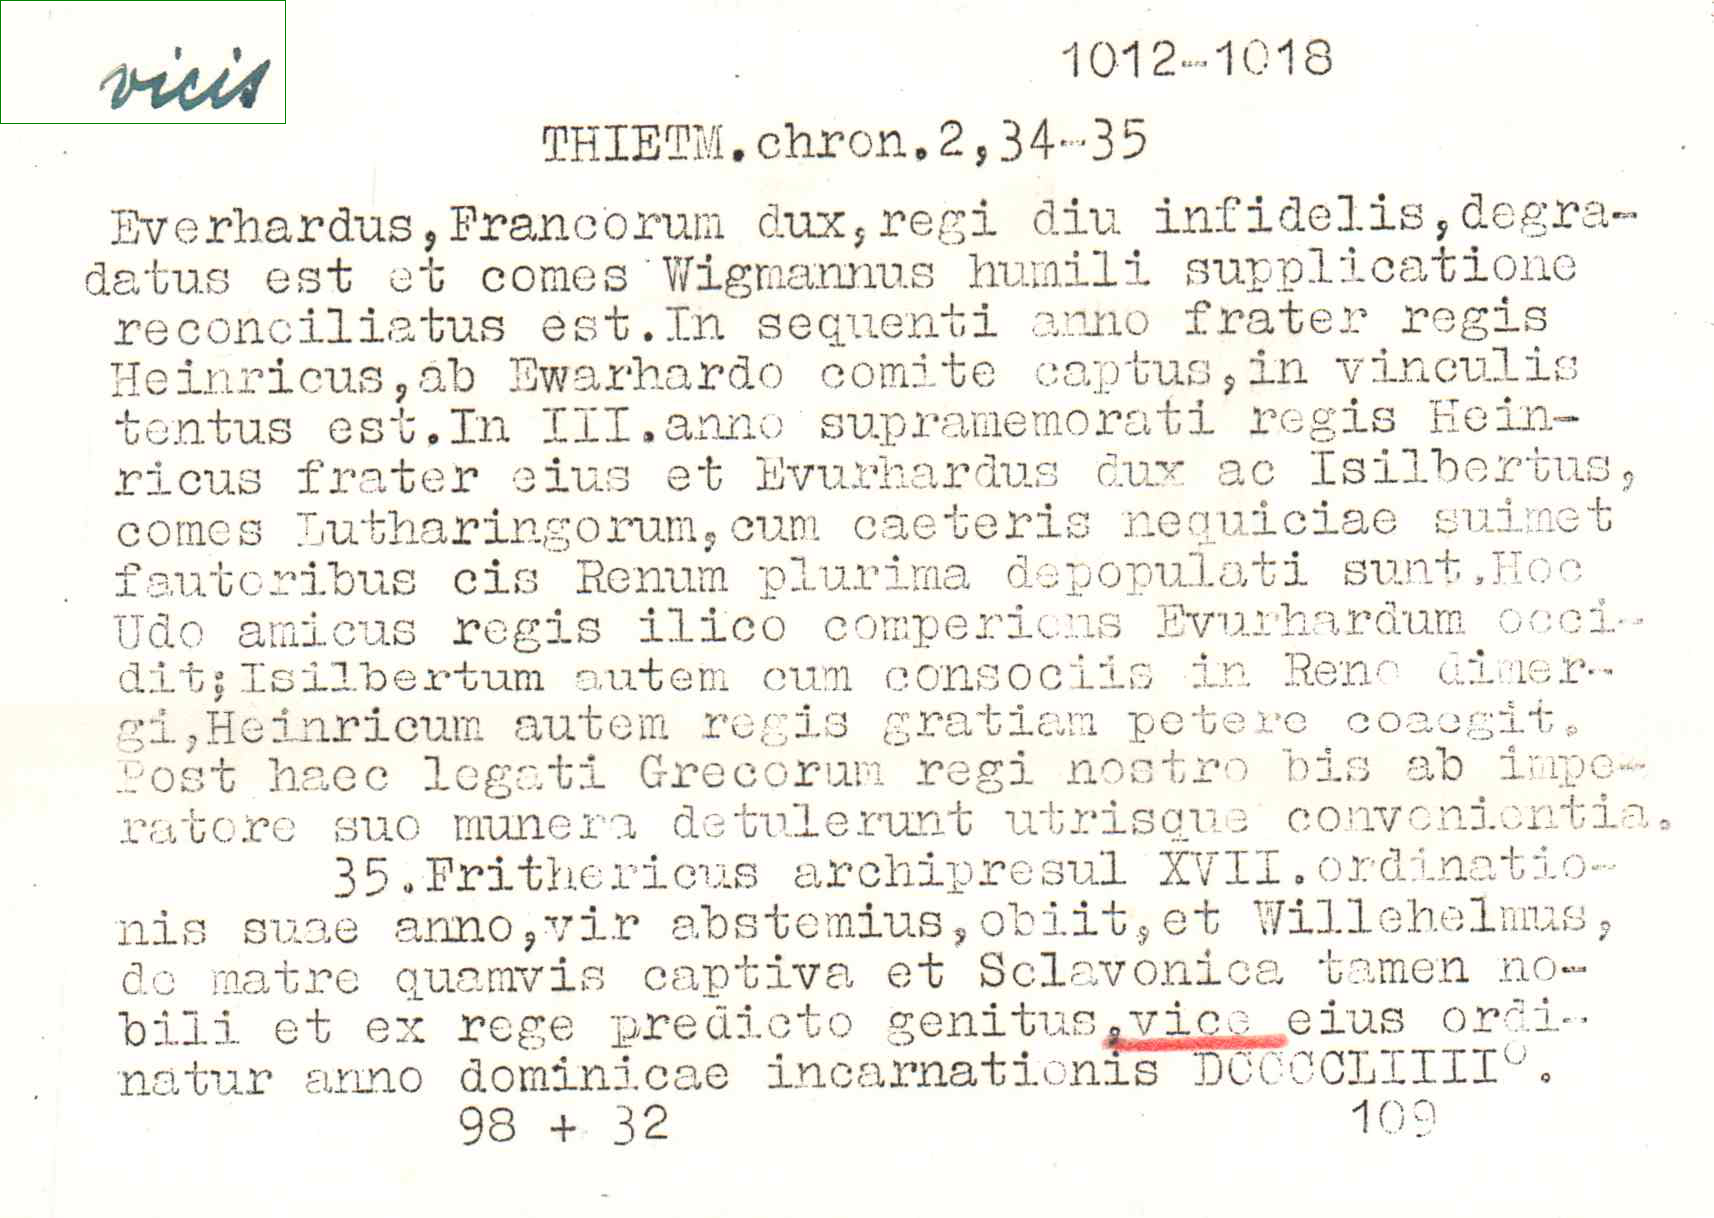

In [17]:
path_images= "Z:/MLW/zettel/"
image = Image.open(os.path.join(path_images, str(total_data.iloc[532]["id"])+".jpg"), mode="r")
x1 = total_data.iloc[532]["x1"]
y1 = total_data.iloc[532]["y1"]
x2 = total_data.iloc[532]["x2"]
y2 = total_data.iloc[532]["y2"]
img = ImageDraw.Draw(image)
img.rectangle([(x1,y1),(x2,y2)], outline ="green")

from IPython import display
display.display(image)

In [18]:
path_to_save= "../data/interim/data_to_label.csv"
data_to_label= total_data.iloc[0:500,].copy()

data_to_label.to_csv(path_to_save, index=False)

In [20]:
data_to_label[data_to_label["id"]==124486]

id    lemma  length_lemma    x1   y1     x2     y2  length  height
264  124486  superus             7  58.0  5.0  509.0  191.0   451.0   186.0

(array([5.540e+02, 2.562e+03, 1.545e+03, 6.610e+02, 2.180e+02, 1.430e+02,
        7.700e+01, 3.800e+01, 5.000e+00, 1.000e+00]),
 array([ 107. ,  224.2,  341.4,  458.6,  575.8,  693. ,  810.2,  927.4,
        1044.6, 1161.8, 1279. ]),
 <BarContainer object of 10 artists>)

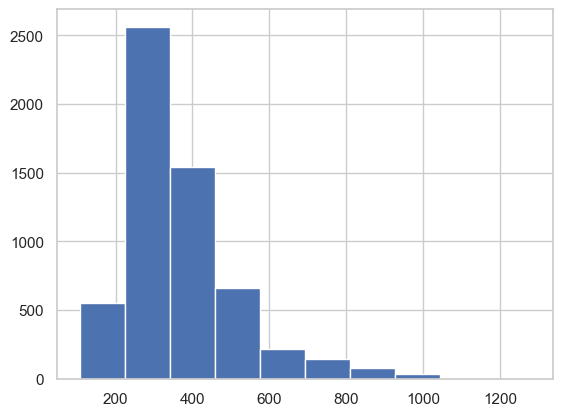

In [81]:
plt.hist(outputs_bb_df["length"])

<AxesSubplot:xlabel='length'>

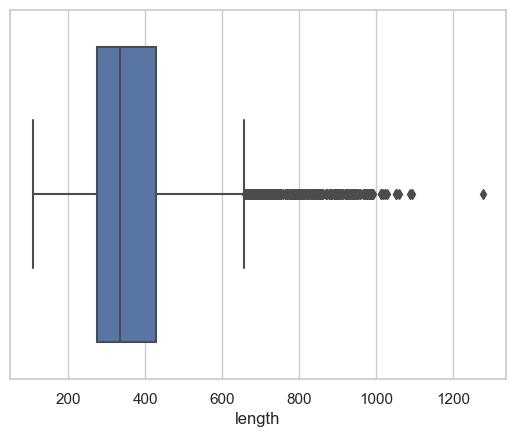

In [82]:
sns.set(style='whitegrid')
sns.boxplot(data = outputs_bb_df, x = "length")

(array([4.510e+02, 1.187e+03, 2.298e+03, 1.464e+03, 3.370e+02, 5.700e+01,
        5.000e+00, 2.000e+00, 0.000e+00, 3.000e+00]),
 array([ 18. ,  53.8,  89.6, 125.4, 161.2, 197. , 232.8, 268.6, 304.4,
        340.2, 376. ]),
 <BarContainer object of 10 artists>)

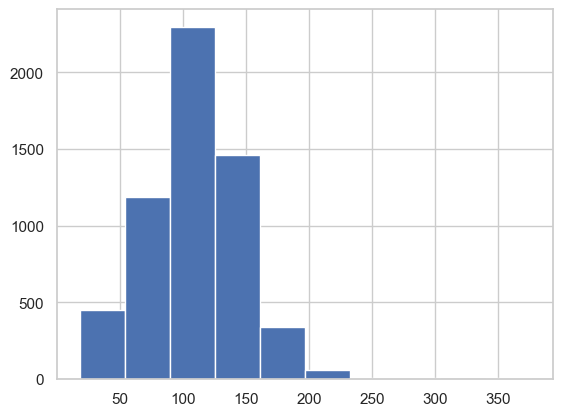

In [83]:
plt.hist(outputs_bb_df["height"])

<AxesSubplot:xlabel='height'>

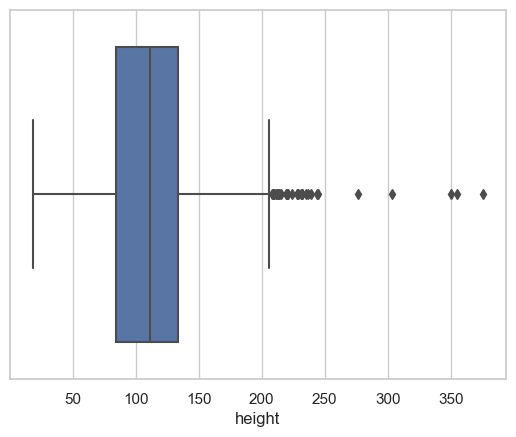

In [84]:
sns.set(style='whitegrid')
sns.boxplot(data = outputs_bb_df, x = "height")

In [85]:
# Getting the outliers
def get_outliers(data, column:str) -> pd.DataFrame:
    q1 = data[column].quantile(0.25)
    q3= data[column].quantile(0.75)
    IQR = q3 - q1
    data["outliers"+"_"+column] = ["yes" if ((d<(q1-1.5*IQR)) | (d>(q3+1.5*IQR))) else "no" for d in data[column]]
    return data

get_outliers(outputs_bb_df, "length")
get_outliers(outputs_bb_df,"height")

id     x1    y1     x2     y2  length  height outliers_length  \
0     213894  217.0  70.0  589.0  202.0   372.0   132.0              no   
1     210622   61.0  35.0  282.0  122.0   221.0    87.0              no   
2     198359  105.0  32.0  402.0  191.0   297.0   159.0              no   
3      37639   51.0  51.0  350.0  184.0   299.0   133.0              no   
4     297240   46.0  71.0  279.0  156.0   233.0    85.0              no   
...      ...    ...   ...    ...    ...     ...     ...             ...   
5994   47344  199.0  83.0  451.0  168.0   252.0    85.0              no   
5995  207390  163.0  81.0  436.0  203.0   273.0   122.0              no   
5996  211066  105.0  63.0  290.0  143.0   185.0    80.0              no   
5997  210113  160.0  72.0  490.0  183.0   330.0   111.0              no   
5998   96330  115.0  50.0  452.0  187.0   337.0   137.0              no   

     outliers_height  
0                 no  
1                 no  
2                 no  
3                 no  
4                 no  
...              ...  
5994              no  
5995              no  
5996              no  
5997              no  
5998              no  

[5804 rows x 9 columns]

In [19]:
summary_length = total_data.groupby(["length_lemma"])["length"].mean().reset_index()
summary_length["q1"] = total_data.groupby(["length_lemma"])["length"].quantile(0.25).reset_index()["length"]
summary_length["q3"] = total_data.groupby(["length_lemma"])["length"].quantile(0.75).reset_index()["length"]
summary_length["min"] = total_data.groupby(["length_lemma"])["length"].min().reset_index()["length"]

In [20]:
summary_length
# We can clearly see that the

length_lemma      length      q1      q3    min
0              2  502.554795  366.75  662.50  107.0
1              3  365.142693  211.00  477.00  109.0
2              4  315.959596  229.00  342.25  165.0
3              5  325.554926  267.00  338.00  170.0
4              6  353.607965  298.00  372.75  219.0
5              7  378.152632  324.00  406.00  247.0
6              8  405.038363  360.00  432.00  286.0
7              9  443.369811  393.00  479.00  317.0
8             10  478.476190  417.25  505.75  345.0
9             11  528.357798  482.00  557.00  380.0
10            12  525.944444  507.50  546.50  439.0
11            13  592.809524  533.00  620.00  482.0
12            14  569.750000  542.25  593.50  525.0
13            15  655.000000  655.00  655.00  655.0
14            17  841.000000  841.00  841.00  841.0

In [23]:
outliers = total_data[(total_data["outliers_height"]=="no") & (total_data["outliers_length"]=="yes")]
outliers.reset_index(drop=True,inplace=True)

In [24]:
outliers

id          lemma  length_lemma     x1     y1      x2     y2  length  \
0      3837  sacramentalis            13   72.0   43.0   759.0  121.0   687.0   
1     19608           scio             4  411.0  190.0  1148.0  229.0   737.0   
2     19631           scio             4  134.0   99.0   930.0  191.0   796.0   
3     19674           scio             4  156.0   92.0   897.0  268.0   741.0   
4     22728         scribo             6  149.0   81.0   838.0  196.0   689.0   
..      ...            ...           ...    ...    ...     ...    ...     ...   
335  307558            non             3  205.0  126.0   884.0  223.0   679.0   
336  307677            non             3  168.0   89.0  1099.0  182.0   931.0   
337  307720            non             3  177.0  120.0   993.0  185.0   816.0   
338  307730            non             3  168.0  100.0   902.0  227.0   734.0   
339  308319    nihilominus            11   21.0   19.0   766.0  110.0   745.0   

     height outliers_length outliers_height  
0      78.0             yes              no  
1      39.0             yes              no  
2      92.0             yes              no  
3     176.0             yes              no  
4     115.0             yes              no  
..      ...             ...             ...  
335    97.0             yes              no  
336    93.0             yes              no  
337    65.0             yes              no  
338   127.0             yes              no  
339    91.0             yes              no  

[340 rows x 11 columns]

In [25]:
# path_images= "Z:/MLW/zettel/"
# files = [d for d in outliers["id"]]
# images = [Image.open(os.path.join(path_images, i+".jpg"), mode="r") for i in files]
# outliers["images"] = images

In [40]:
path_images= "Z:/MLW/zettel/"
files = [d for d in total_data.iloc[0:10,]["id"]]
images = [Image.open(os.path.join(path_images, str(i)+".jpg"), mode="r") for i in files]
for i in range(10):
    x1 = total_data.iloc[i]["x1"]
    y1 = total_data.iloc[i]["y1"]
    x2 = total_data.iloc[i]["x2"]
    y2 = total_data.iloc[i]["y2"]
    img = ImageDraw.Draw(images[i])
    img.rectangle([(x1,y1),(x2,y2)], outline ="green")

In [64]:
total_data[0:100]

id     lemma  length_lemma     x1     y1     x2     y2  length  height  \
0     962  kalendae             8  199.0   52.0  602.0  196.0   403.0   144.0   
1     966  kalendae             8   62.0   18.0  483.0  157.0   421.0   139.0   
2     966  kalendae             8   62.0   18.0  483.0  157.0   421.0   139.0   
3     974  kalendae             8   92.0   35.0  481.0  154.0   389.0   119.0   
4     983  kalendae             8  146.0   74.0  556.0  172.0   410.0    98.0   
..    ...       ...           ...    ...    ...    ...    ...     ...     ...   
95  13012    saevus             6  142.0  117.0  436.0  202.0   294.0    85.0   
96  13025    saevus             6  182.0   87.0  486.0  195.0   304.0   108.0   
97  13059     sagax             5  150.0   71.0  433.0  199.0   283.0   128.0   
98  13066     sagax             5  106.0   89.0  418.0  191.0   312.0   102.0   
99  13069     sagax             5  131.0   52.0  544.0  220.0   413.0   168.0   

   outliers_length outliers_height  
0               no              no  
1               no              no  
2               no              no  
3               no              no  
4               no              no  
..             ...             ...  
95              no              no  
96              no              no  
97              no              no  
98              no              no  
99              no              no  

[100 rows x 11 columns]

In [71]:
data_small= outliers.iloc[0:10,].copy()
data_small

id          lemma  length_lemma     x1     y1      x2     y2  length  \
0   3837  sacramentalis            13   72.0   43.0   759.0  121.0   687.0   
1  19608           scio             4  411.0  190.0  1148.0  229.0   737.0   
2  19631           scio             4  134.0   99.0   930.0  191.0   796.0   
3  19674           scio             4  156.0   92.0   897.0  268.0   741.0   
4  22728         scribo             6  149.0   81.0   838.0  196.0   689.0   
5  22932         scribo             6  151.0   52.0   824.0  186.0   673.0   
6  22932         scribo             6  151.0   52.0   824.0  186.0   673.0   
7  23566       secundum             8  144.0   86.0   979.0  201.0   835.0   
8  23627       secundum             8  118.0   89.0   949.0  187.0   831.0   
9  23647       secundum             8  111.0  125.0   812.0  221.0   701.0   

   height outliers_length outliers_height  
0    78.0             yes              no  
1    39.0             yes              no  
2    92.0             yes              no  
3   176.0             yes              no  
4   115.0             yes              no  
5   134.0             yes              no  
6   134.0             yes              no  
7   115.0             yes              no  
8    98.0             yes              no  
9    96.0             yes              no

In [68]:
data_small_2 = pd.read_csv(path_to_save)
data_small_2

id          lemma  length_lemma     x1     y1      x2     y2  length  \
0   3837  sacramentalis            13   72.0   43.0   759.0  121.0   687.0   
1  19608           scio             4  411.0  190.0  1148.0  229.0   737.0   
2  19631           scio             4  134.0   99.0   930.0  191.0   796.0   
3  19674           scio             4  156.0   92.0   897.0  268.0   741.0   
4  22728         scribo             6  149.0   81.0   838.0  196.0   689.0   
5  22932         scribo             6  151.0   52.0   824.0  186.0   673.0   
6  22932         scribo             6  151.0   52.0   824.0  186.0   673.0   
7  23566       secundum             8  144.0   86.0   979.0  201.0   835.0   
8  23627       secundum             8  118.0   89.0   949.0  187.0   831.0   
9  23647       secundum             8  111.0  125.0   812.0  221.0   701.0   

   height outliers_length outliers_height labeler manual_check  
0    78.0             yes              no  Gilary            y  
1    39.0             yes              no  Gilary            x  
2    92.0             yes              no  Gilary            x  
3   176.0             yes              no  Gilary            x  
4   115.0             yes              no  Gilary            y  
5   134.0             yes              no  Gilary            y  
6   134.0             yes              no  Gilary            x  
7   115.0             yes              no     NaN          NaN  
8    98.0             yes              no     NaN          NaN  
9    96.0             yes              no     NaN          NaN

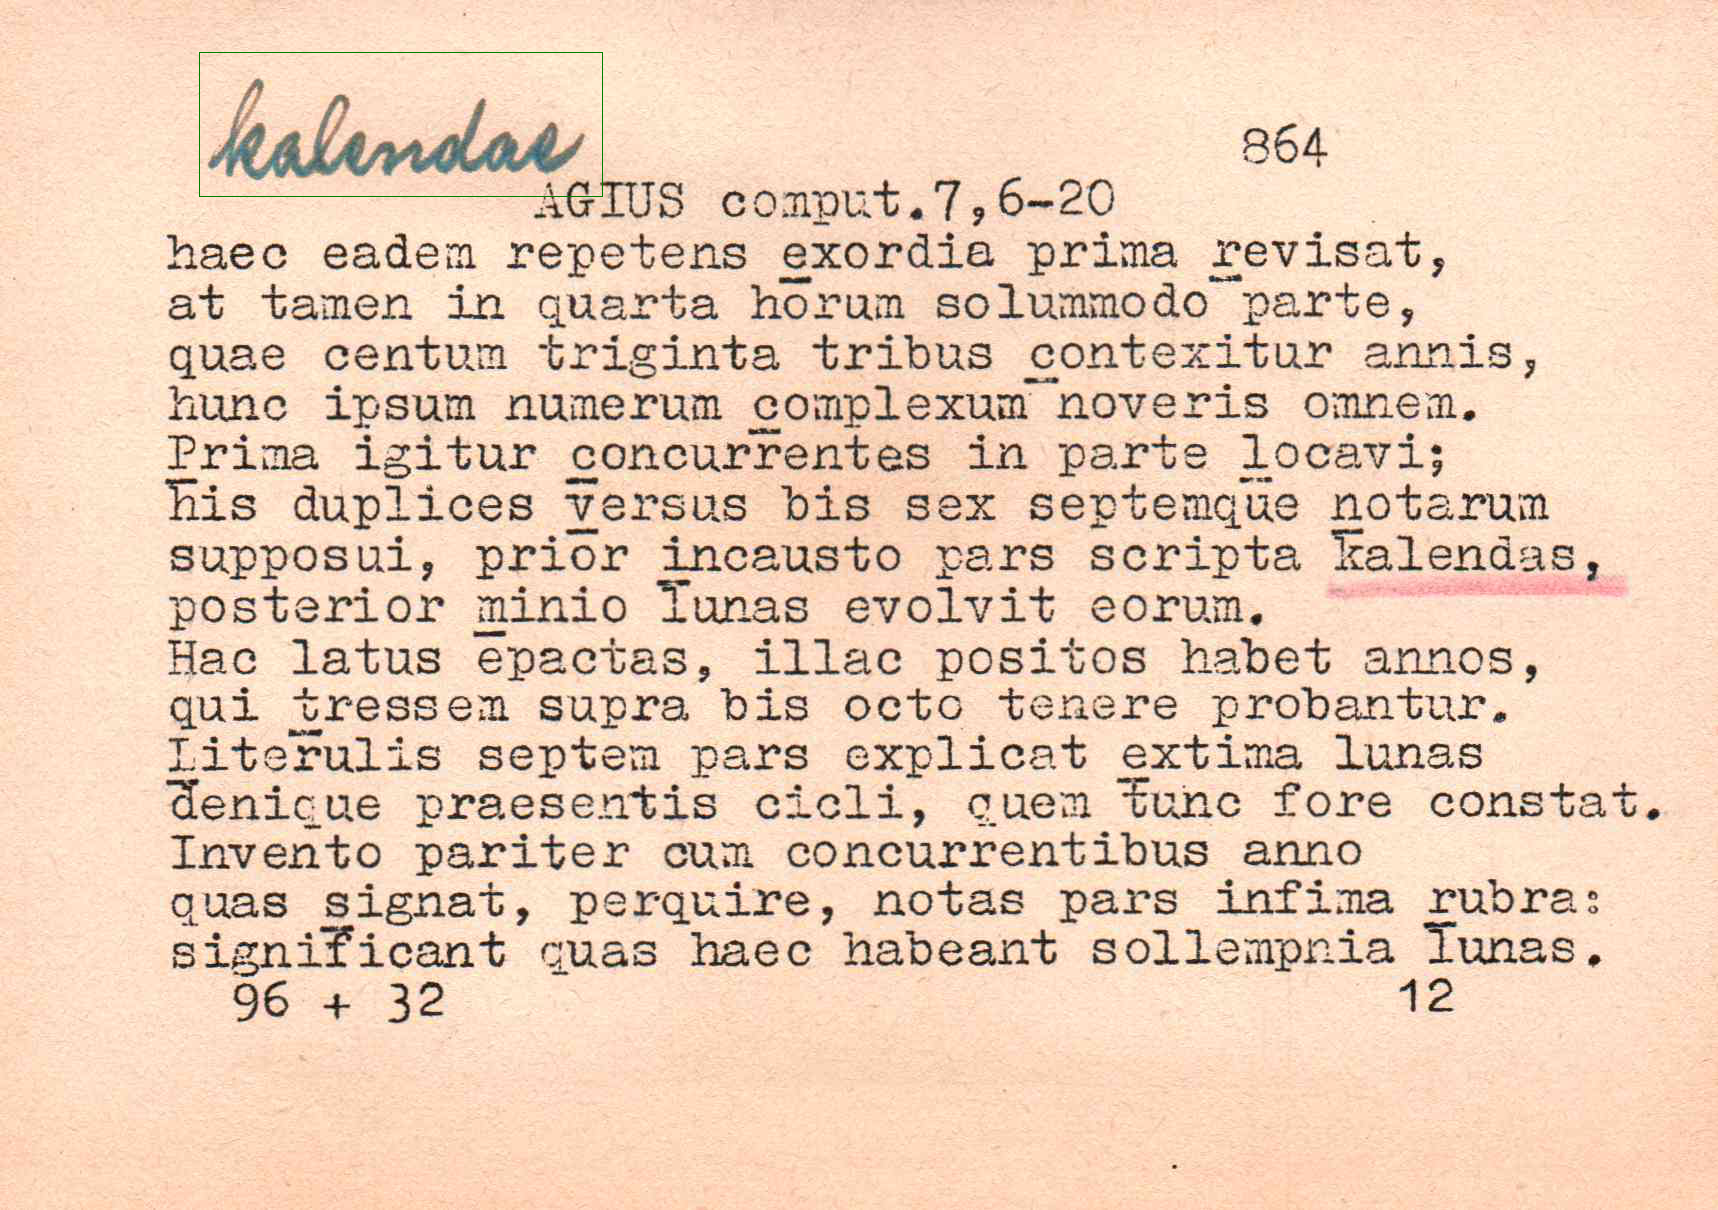

In [52]:
from IPython import display
display.display(data_small.iloc[0]["image"])

In [126]:
# [cv2.rectangle(i, pt1 = (outliers["x1"].astype("float"), ), pt2= (), color = (255, 0, 0), thickness= 3) for i in outliers["images"]]

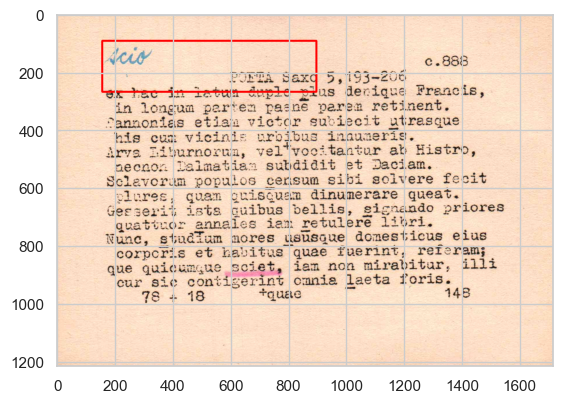

In [29]:
prueba = cv2.imread(os.path.join(path_images, str(outliers["id"][3])+".jpg"))
prueba = cv2.cvtColor(prueba, cv2.COLOR_BGR2RGB)
x1 = round(float(outliers["x1"][3]))
y1 = round(float(outliers["y1"][3]))
x2 = round(float(outliers["x2"][3]))
y2 = round(float(outliers["y2"][3]))
cv2.rectangle(prueba, pt1=(x1,y1), pt2 =(x2,y2), color = (255, 0, 0),thickness = 5)
plt.imshow(prueba)

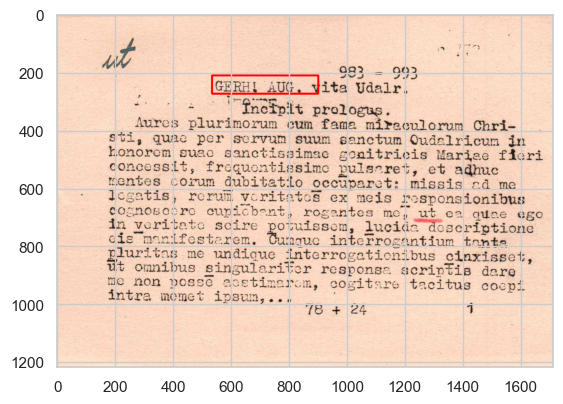

In [30]:
prueba = cv2.imread(os.path.join(path_images, str(total_data["id"][3453])+".jpg"))
prueba = cv2.cvtColor(prueba, cv2.COLOR_BGR2RGB)
x1 = round(float(total_data["x1"][3453]))
y1 = round(float(total_data["y1"][3453]))
x2 = round(float(total_data["x2"][3453]))
y2 = round(float(total_data["y2"][3453]))
cv2.rectangle(prueba, pt1=(x1,y1), pt2 =(x2,y2), color = (255, 0, 0),thickness = 5)
plt.imshow(prueba)

In [129]:
prueba_2 = Image.open(os.path.join(path_images, str(total_data["id"][3419])+".jpg"), mode="r")
img = ImageDraw.Draw(prueba_2)
img.rectangle([(x1,y1),(x2,y2)], outline ="green")
prueba_2.show()

In [130]:
total_data[total_data["lemma"]=="mos"]

id lemma  length_lemma     x1      y1      x2      y2  length  \
5349  295347   mos             3  431.0  1018.0  1018.0  1018.0   587.0   
5350  295362   mos             3   60.0   259.0   259.0   259.0   199.0   
5351  295366   mos             3  149.0   635.0   635.0   635.0   486.0   
5352  295373   mos             3  161.0   641.0   641.0   641.0   480.0   
5353  295378   mos             3  141.0   612.0   612.0   612.0   471.0   
5354  295423   mos             3  210.0   392.0   392.0   392.0   182.0   
5355  295425   mos             3  160.0   730.0   730.0   730.0   570.0   
5356  295437   mos             3  120.0   293.0   293.0   293.0   173.0   
5357  295443   mos             3  131.0   305.0   305.0   305.0   174.0   
5358  295450   mos             3  143.0   327.0   327.0   327.0   184.0   
5427  296672   mos             3  119.0   342.0   342.0   342.0   223.0   
5428  296689   mos             3  362.0   823.0   823.0   823.0   461.0   
5429  296696   mos             3  150.0   816.0   816.0   816.0   666.0   
5430  296709   mos             3  168.0   830.0   830.0   830.0   662.0   
5431  296754   mos             3  387.0   834.0   834.0   834.0   447.0   
5432  296780   mos             3   58.0   345.0   345.0   345.0   287.0   
5433  296810   mos             3   58.0  1042.0  1042.0  1042.0   984.0   
5434  296819   mos             3  169.0   347.0   347.0   347.0   178.0   
5435  296822   mos             3  131.0   817.0   817.0   817.0   686.0   
5436  296860   mos             3    9.0   816.0   816.0   816.0   807.0   
5437  296868   mos             3  382.0   919.0   919.0   919.0   537.0   
5438  296922   mos             3   74.0   327.0   327.0   327.0   253.0   
5439  296924   mos             3   52.0  1028.0  1028.0  1028.0   976.0   
5440  296927   mos             3   51.0   274.0   274.0   274.0   223.0   

      height outliers_length outliers_height  
5349     0.0              no              no  
5350     0.0              no              no  
5351     0.0              no              no  
5352     0.0              no              no  
5353     0.0              no              no  
5354     0.0              no              no  
5355     0.0              no              no  
5356     0.0              no              no  
5357     0.0              no              no  
5358     0.0              no              no  
5427     0.0              no              no  
5428     0.0              no              no  
5429     0.0             yes              no  
5430     0.0             yes              no  
5431     0.0              no              no  
5432     0.0              no              no  
5433     0.0             yes              no  
5434     0.0              no              no  
5435     0.0             yes              no  
5436     0.0             yes              no  
5437     0.0              no              no  
5438     0.0              no              no  
5439     0.0             yes              no  
5440     0.0              no              no

In [131]:
total_data.iloc[3419,:]

id                 217744
lemma                  ut
length_lemma            2
x1                   52.0
y1                  225.0
x2                  225.0
y2                  225.0
length              173.0
height                0.0
outliers_length        no
outliers_height        no
Name: 3419, dtype: object

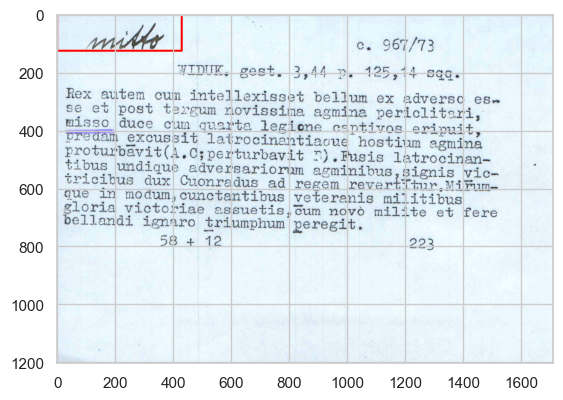

In [31]:
prueba = cv2.imread(os.path.join(path_images, str(total_data["id"][5193])+".jpg"))
x1 = round(float(total_data["x1"][5193]))
y1 = round(float(total_data["y1"][5193]))
x2 = round(float(total_data["x2"][5193]))
y2 = round(float(total_data["y2"][5193]))
cv2.rectangle(prueba, pt1=(x1,y1), pt2 =(x2,y2), color = (255, 0, 0),thickness = 5)
plt.imshow(prueba)